In [1]:
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score

In [6]:
dataset_folder = os.environ['HOME'] + '/workspace/Maestria/Videos'
experiment_folder = os.environ['HOME'] + '/workspace/Maestria/Videos/frcnn-restnet50-tunned'

test_file = os.path.join(dataset_folder, 'MOV_0861.mp4.json')
experiment_file = os.path.join(experiment_folder, 'MOV_0861_vvc.json')

test_file

'/home/juan/workspace/Maestria/Videos/MOV_0861.mp4.json'

In [7]:
def vott_to_dataframe(json_file):
    test_annotations = {}

    df = pd.DataFrame()

    with open(json_file) as json_data:
        data = json.load(json_data)

        for frame_id, boxes in data['frames'].items():
            if not frame_id in test_annotations:
                test_annotations[frame_id] = {}
            for box in boxes:
                for tag in box['tags']:
                    if not tag in test_annotations[frame_id]:
                        test_annotations[frame_id][tag] = 0
                    test_annotations[frame_id][tag] += 1

    df = pd.DataFrame.from_dict(test_annotations, orient='index')
    df = df.fillna(0)
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    
    return df
    
test = vott_to_dataframe(test_file)
test.head()

,car,motorbike,taxi
1,0.0,2.0,1.0
2,0.0,2.0,1.0
3,0.0,2.0,1.0
4,0.0,2.0,1.0
5,0.0,2.0,1.0


In [9]:
def vvc_to_df(json_file):
    summary = {}

    df = pd.DataFrame()

    with open(json_file) as json_data:
        data = json.load(json_data)
        for frame_id, objects in data['frames'].items():
            
            if not frame_id in summary:
                summary[frame_id] = {}
            
            for obj in objects['objects']:
                tag = obj['tag']
                
                if not tag in summary[frame_id]:
                    summary[frame_id][tag] = 0
                
                summary[frame_id][tag] += 1

    df = pd.DataFrame.from_dict(summary, orient='index')
    df = df.fillna(0)
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    
    df.index += 1
    
    return df
    
experiment = vvc_to_df(experiment_file)
experiment.head()

,motorbike,taxi
1,2.0,1.0
2,2.0,1.0
3,2.0,1.0
4,2.0,1.0
5,2.0,1.0


In [10]:
result = test.sub(experiment, axis='columns').abs().div(test)
#result = result.set_index(pd.to_numeric(result.index))
result.sort_index(inplace=True, kind='mergesort')
result.tail()

,car,motorbike,taxi
82,NaN,NaN,NaN
83,NaN,NaN,NaN
84,NaN,NaN,NaN
85,NaN,NaN,NaN
86,NaN,NaN,NaN


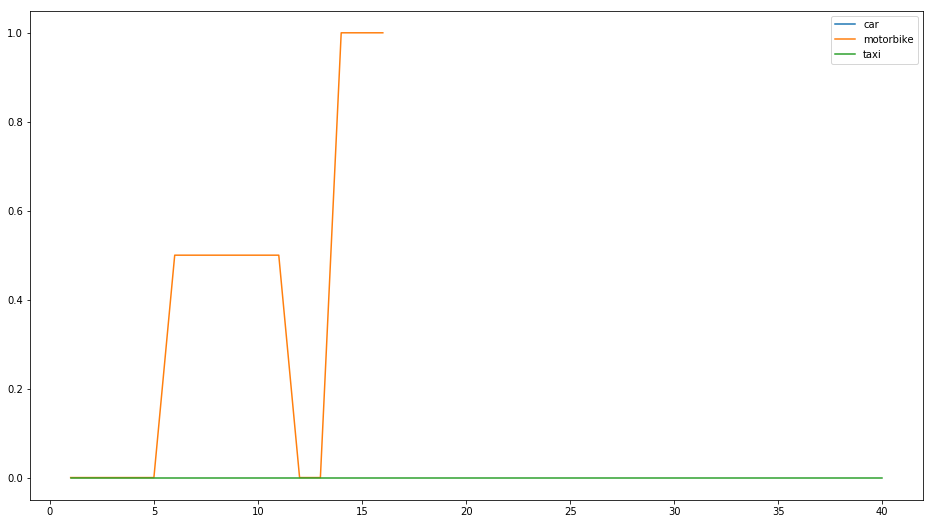

In [11]:
result.plot(figsize=(16, 9))

car            NaN
motorbike    0.375
taxi         0.000
dtype: float64


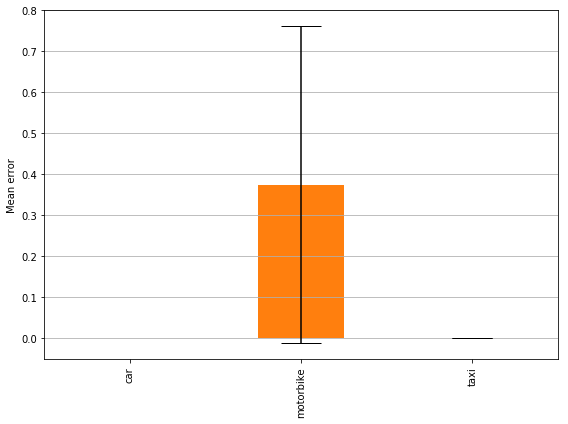

In [12]:
avg_error = result.mean()

print(avg_error)

stds = result.std()

plt.figure()

ax = avg_error.plot.bar(yerr=stds, figsize=(8, 6), capsize=20)

plt.grid(axis='y')

ax.set_ylabel('Mean error')

plt.tight_layout()

fig = ax.get_figure()
fig.savefig('./mean_error.png')